## AEGAN Implementation

<code>[Статья "Auto-Embedding Generative Adversarial Networks for High Resolution Image Synthesis"](https://arxiv.org/pdf/1903.11250.pdf)
</code>

Процесс обучения:

![AEGAN Architecture](./aegan.png)

In [1]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid", font_scale=1.2)

In [2]:
!unzip pokemons_archive.zip

Archive:  pokemons_archive.zip
replace images/Abomasnow/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
root_dir = "./images"
stats = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]
image_size = 64
batch_size = 32
input_channels = 3
latent_size = 16

In [3]:
dataset = ImageFolder(root=root_dir, transform=tt.Compose([    
    tt.Resize((image_size, image_size)),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

In [4]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

##### Show Faces from Dataset

In [5]:
def denorm_image(tensor):
    for ch in range(input_channels):
        tensor[ch] = tensor[ch] * stats[1][ch] + stats[0][ch]

    return tensor

In [6]:
def show_images(batch: torch.Tensor, image_count: int = 25, denorm=True):
    indices = np.random.choice(batch.shape[0], min(batch.shape[0], image_count), replace=False)
    images = []

    for index in indices:
        if denorm:
            images.append(denorm_image(batch[index].cpu().detach()))
        else:
            images.append(batch[index].clone().cpu().detach())

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    grid = make_grid(torch.stack(images), nrow=min(5, min(batch.shape[0], image_count))).permute(1, 2, 0)
    ax.imshow(grid)

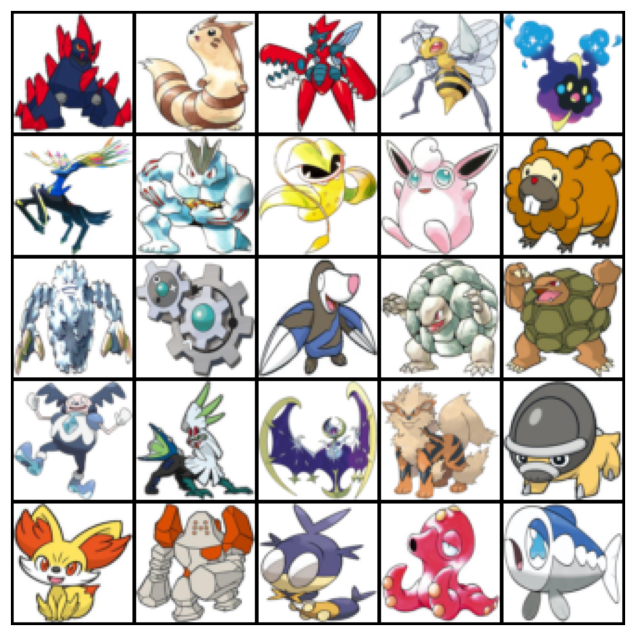

In [7]:
for (images, _) in dataloader:
    show_images(images)
    break

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [10]:
dataloader = DeviceDataLoader(dataloader, device)

## Model Architecture


In [11]:
from torchsummary import summary

In [157]:
class Encoder(nn.Module):
    def __init__(self, input_channels: int, latent_size: int):
        super().__init__()

        self.__conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(True)
            # out: 64 x 64 x 64
        )

        self.__conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 32 x 32
        )

        self.__conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 16 x 16
        )

        self.__conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 8 x 8
        )

        self.__conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4
        )

        self.__conv6 = nn.Conv2d(512, latent_size, kernel_size=4, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.__conv1(x)
        x = self.__conv2(x)
        x = self.__conv3(x)
        x = self.__conv4(x)
        x = self.__conv5(x)
        return self.__conv6(x)

encoder = Encoder(input_channels, latent_size)

In [158]:
summary(encoder, (input_channels, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,728
|    └─LeakyReLU: 2-2                    [-1, 64, 64, 64]          --
├─Sequential: 1-2                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-3                       [-1, 128, 32, 32]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 32, 32]         --
├─Sequential: 1-3                        [-1, 256, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 16, 16]         524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-8                    [-1, 256, 16, 16]         --
├─Sequential: 1-4                        [-1, 512, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 8, 8]           2,0

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,728
|    └─LeakyReLU: 2-2                    [-1, 64, 64, 64]          --
├─Sequential: 1-2                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-3                       [-1, 128, 32, 32]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 32, 32]         --
├─Sequential: 1-3                        [-1, 256, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 16, 16]         524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-8                    [-1, 256, 16, 16]         --
├─Sequential: 1-4                        [-1, 512, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 8, 8]           2,0

In [159]:
class Generator(nn.Module):
    def __init__(self, latent_size: int, input_channels: int):
        super().__init__()

        self.__tr_conv1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 4 x 4
        )

        self.__tr_conv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 8 x 8
        )

        self.__tr_conv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 16 x 16
        )

        self.__tr_conv4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # out: 32 x 32 x 32
        )

        self.__tr_conv5 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # out: 32 x 64 x 64
        )

        self.__tr_conv6 = nn.Sequential(
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.__tr_conv1(x)
        x = self.__tr_conv2(x)
        x = self.__tr_conv3(x)
        x = self.__tr_conv4(x)
        x = self.__tr_conv5(x)
        return self.__tr_conv6(x)

generator = Generator(latent_size, input_channels)

In [160]:
summary(generator, (latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─ConvTranspose2d: 2-1              [-1, 256, 4, 4]           65,536
|    └─BatchNorm2d: 2-2                  [-1, 256, 4, 4]           512
|    └─ReLU: 2-3                         [-1, 256, 4, 4]           --
├─Sequential: 1-2                        [-1, 128, 8, 8]           --
|    └─ConvTranspose2d: 2-4              [-1, 128, 8, 8]           524,288
|    └─BatchNorm2d: 2-5                  [-1, 128, 8, 8]           256
|    └─ReLU: 2-6                         [-1, 128, 8, 8]           --
├─Sequential: 1-3                        [-1, 64, 16, 16]          --
|    └─ConvTranspose2d: 2-7              [-1, 64, 16, 16]          131,072
|    └─BatchNorm2d: 2-8                  [-1, 64, 16, 16]          128
|    └─ReLU: 2-9                         [-1, 64, 16, 16]          --
├─Sequential: 1-4                        [-1, 32, 32, 32]          -

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─ConvTranspose2d: 2-1              [-1, 256, 4, 4]           65,536
|    └─BatchNorm2d: 2-2                  [-1, 256, 4, 4]           512
|    └─ReLU: 2-3                         [-1, 256, 4, 4]           --
├─Sequential: 1-2                        [-1, 128, 8, 8]           --
|    └─ConvTranspose2d: 2-4              [-1, 128, 8, 8]           524,288
|    └─BatchNorm2d: 2-5                  [-1, 128, 8, 8]           256
|    └─ReLU: 2-6                         [-1, 128, 8, 8]           --
├─Sequential: 1-3                        [-1, 64, 16, 16]          --
|    └─ConvTranspose2d: 2-7              [-1, 64, 16, 16]          131,072
|    └─BatchNorm2d: 2-8                  [-1, 64, 16, 16]          128
|    └─ReLU: 2-9                         [-1, 64, 16, 16]          --
├─Sequential: 1-4                        [-1, 32, 32, 32]          -

In [161]:
class ImageDiscriminator(nn.Module):
    def __init__(self, input_channels: int):
        super().__init__()

        self.__conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(True)
            # out: 64 x 64 x 64
        )

        self.__conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 32 x 32
        )

        self.__conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 16 x 16
        )

        self.__conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 8 x 8
        )

        self.__conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4
        )

        self.__conv6 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=True),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.__conv1(x)
        x = self.__conv2(x)
        x = self.__conv3(x)
        x = self.__conv4(x)
        x = self.__conv5(x)
        return self.__conv6(x)

img_discriminator = ImageDiscriminator(input_channels)

In [162]:
summary(img_discriminator, (input_channels, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,728
|    └─LeakyReLU: 2-2                    [-1, 64, 64, 64]          --
├─Sequential: 1-2                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-3                       [-1, 128, 32, 32]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 32, 32]         --
├─Sequential: 1-3                        [-1, 256, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 16, 16]         524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-8                    [-1, 256, 16, 16]         --
├─Sequential: 1-4                        [-1, 512, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 8, 8]           2,0

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,728
|    └─LeakyReLU: 2-2                    [-1, 64, 64, 64]          --
├─Sequential: 1-2                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-3                       [-1, 128, 32, 32]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 32, 32]         --
├─Sequential: 1-3                        [-1, 256, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 16, 16]         524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-8                    [-1, 256, 16, 16]         --
├─Sequential: 1-4                        [-1, 512, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 8, 8]           2,0

In [163]:
class NoiseDiscriminator(nn.Module):
    def __init__(self, latent_size: int):
        super().__init__()

        self.__tr_conv1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 4 x 4
        )

        self.__tr_conv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 4 x 4
        )

        self.__tr_conv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 4 x 4
        )

        self.__tr_conv4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # out: 32 x 4 x 4
        )

        self.__conv = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=5, stride=2, padding=1, bias=True),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.__tr_conv1(x)
        x = self.__tr_conv2(x)
        x = self.__tr_conv3(x)
        x = self.__tr_conv4(x)
        return self.__conv(x)

latent_discriminator = NoiseDiscriminator(latent_size)

In [164]:
summary(latent_discriminator, (latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─ConvTranspose2d: 2-1              [-1, 256, 4, 4]           65,536
|    └─BatchNorm2d: 2-2                  [-1, 256, 4, 4]           512
|    └─ReLU: 2-3                         [-1, 256, 4, 4]           --
├─Sequential: 1-2                        [-1, 128, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 128, 4, 4]           294,912
|    └─BatchNorm2d: 2-5                  [-1, 128, 4, 4]           256
|    └─ReLU: 2-6                         [-1, 128, 4, 4]           --
├─Sequential: 1-3                        [-1, 64, 4, 4]            --
|    └─ConvTranspose2d: 2-7              [-1, 64, 4, 4]            73,728
|    └─BatchNorm2d: 2-8                  [-1, 64, 4, 4]            128
|    └─ReLU: 2-9                         [-1, 64, 4, 4]            --
├─Sequential: 1-4                        [-1, 32, 4, 4]            --

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─ConvTranspose2d: 2-1              [-1, 256, 4, 4]           65,536
|    └─BatchNorm2d: 2-2                  [-1, 256, 4, 4]           512
|    └─ReLU: 2-3                         [-1, 256, 4, 4]           --
├─Sequential: 1-2                        [-1, 128, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 128, 4, 4]           294,912
|    └─BatchNorm2d: 2-5                  [-1, 128, 4, 4]           256
|    └─ReLU: 2-6                         [-1, 128, 4, 4]           --
├─Sequential: 1-3                        [-1, 64, 4, 4]            --
|    └─ConvTranspose2d: 2-7              [-1, 64, 4, 4]            73,728
|    └─BatchNorm2d: 2-8                  [-1, 64, 4, 4]            128
|    └─ReLU: 2-9                         [-1, 64, 4, 4]            --
├─Sequential: 1-4                        [-1, 32, 4, 4]            --

In [165]:
sample_dir = "aegan_generated"
os.makedirs(sample_dir, exist_ok=True)

In [166]:
checkpoints = "aegan_checkpoints"
os.makedirs(checkpoints, exist_ok=True)

In [167]:
aegan = {
    "generator": generator.to(device),
    "encoder": encoder.to(device),
    "img_discriminator": img_discriminator.to(device),
    "latent_discriminator": latent_discriminator.to(device)
}

criterions = {
    "generator": nn.L1Loss(),
    "encoder": nn.MSELoss(),
    "img_discriminator": nn.BCELoss(),
    "latent_discriminator": nn.BCELoss()
}


optimizers = {
    "generator": torch.optim.Adam(
        aegan["generator"].parameters(), lr=0.002, betas=(0.5, 0.999), eps=0.00005
    ),
    "encoder": torch.optim.Adam(
        aegan["encoder"].parameters(), lr=0.002, betas=(0.5, 0.999), eps=0.00005
    ),
    "img_discriminator": torch.optim.Adam(
        aegan["img_discriminator"].parameters(), lr=0.002, betas=(0.5, 0.999), eps=0.00005
    ),
    "latent_discriminator": torch.optim.Adam(
        aegan["latent_discriminator"].parameters(), lr=0.002, betas=(0.5, 0.999), eps=0.00005
    )
}

epochs = 5000

#### Noise example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 64, 64])


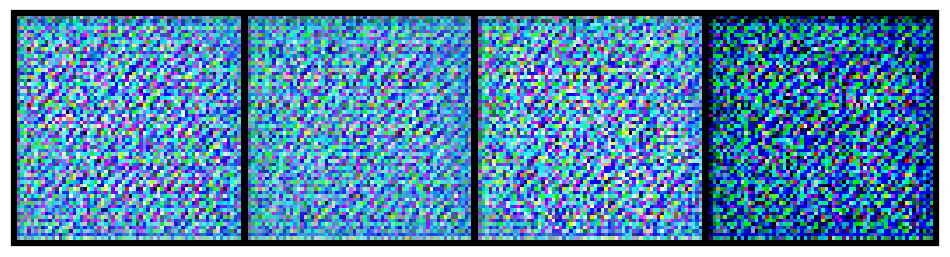

In [168]:
xb = torch.randn(4, latent_size, 1, 1).to(device)
fake_images = aegan["generator"](xb).cpu()
print(fake_images.shape)
show_images(fake_images)

In [169]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

## Training

In [170]:
from datetime import datetime
from time import time
from copy import deepcopy

ALPHA_RECONSTRUCT_IMAGE = 1
ALPHA_RECONSTRUCT_LATENT = 0.5
ALPHA_DISCRIMINATE_IMAGE = 0.005
ALPHA_DISCRIMINATE_LATENT = 0.1

SAVE_EPOCH_INTERVAL = 1
CHECKPOINTS_INTERVAL = 10

def save_samples(index, latent_tensors, show=True, dir=sample_dir):
    fake_images = aegan["generator"](latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm_image(fake_images), os.path.join(dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def train_aegan(epochs):
    torch.cuda.empty_cache() 

    for model in aegan:
        aegan[model].train()

    # Losses & scores
    losses_g = []
    losses_e = []
    losses_img_d = []
    losses_latent_d = []
    losses_img_r = []
    losses_latent_r = []

    now_s = datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

    # Dir for generated images    
    generated_dir = os.path.join(sample_dir, "examples_" + now_s)
    os.makedirs(generated_dir, exist_ok=True)

    # Dir for checkpoints
    cur_checkpoints = os.path.join(checkpoints, "chpt_" + now_s)
    os.makedirs(cur_checkpoints, exist_ok=True)    

    for epoch in range(epochs):
        loss_g_per_epoch = []
        loss_e_per_epoch = []
        loss_img_d_per_epoch = []
        loss_latent_d_per_epoch = []
        loss_img_r_per_epoch = []
        loss_latent_r_per_epoch = []

        for real_images, _ in tqdm(dataloader):
            # Generate latent vectors
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)

            # Train
            x_loss, z_loss, x_reconstruction_loss, z_reconstruction_loss = train_generator_encoder(real_images, latent)
            loss_images, loss_latent = train_discriminators(real_images, latent)

            loss_g_per_epoch.append(x_loss)
            loss_e_per_epoch.append(z_loss)
            loss_img_d_per_epoch.append(loss_images)
            loss_latent_d_per_epoch.append(loss_latent)
            loss_img_r_per_epoch.append(x_reconstruction_loss)
            loss_latent_r_per_epoch.append(z_reconstruction_loss)

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_e.append(np.mean(loss_e_per_epoch))
        losses_img_d.append(np.mean(loss_img_d_per_epoch))
        losses_latent_d.append(np.mean(loss_latent_d_per_epoch))
        losses_img_r.append(np.mean(loss_img_r_per_epoch))
        losses_latent_r.append(np.mean(loss_latent_r_per_epoch))

        # Log losses & scores (last batch)
        print(
            "Epoch [{}/{}], loss_g: {:.4f}, loss_e: {:.4f}, loss_img_d: {:.4f}, loss_latent_d: {:.4f}, loss_img_r: {:.4f}, loss_latent_r: {:.4f}".format(
                epoch + 1,
                epochs,
                losses_g[-1],
                losses_e[-1],
                losses_img_d[-1],
                losses_latent_d[-1],
                losses_img_r[-1],
                losses_latent_r[-1]
            )
        )
        
        # Save generated images
        if (epoch + 1) % SAVE_EPOCH_INTERVAL == 0:
            save_samples(epoch + 1, fixed_latent, show=False, dir=generated_dir)

        # Save checkpoints
        if (epoch + 1) % CHECKPOINTS_INTERVAL == 0:
            for model in aegan:
                torch.save(aegan[model].state_dict(), os.path.join(cur_checkpoints, model + "_" + str(epoch + 1) + ".pt"))

    return losses_g, losses_e, losses_img_d, losses_latent_d, losses_img_r, losses_latent_r

def train_generator_encoder(real_images, latent):
    optimizers["generator"].zero_grad()
    optimizers["encoder"].zero_grad()
    
    x_hat = aegan["generator"](latent)
    z_hat = aegan["encoder"](real_images)
    x_tilde = aegan["generator"](z_hat)
    z_tilde = aegan["encoder"](x_hat)

    x_hat_preds = aegan["img_discriminator"](x_hat)
    z_hat_preds = aegan["latent_discriminator"](z_hat)
    x_tilde_preds = aegan["img_discriminator"](x_tilde)
    z_tilde_preds = aegan["latent_discriminator"](z_tilde)

    true_labels = torch.ones(real_images.size(0), 1, device=device)

    x_hat_loss = criterions["img_discriminator"](x_hat_preds, true_labels)
    z_hat_loss = criterions["latent_discriminator"](z_hat_preds, true_labels)
    x_tilde_loss = criterions["img_discriminator"](x_tilde_preds, true_labels)
    z_tilde_loss = criterions["latent_discriminator"](z_tilde_preds, true_labels)

    x_reconstruction_loss = criterions["generator"](x_tilde, real_images) * ALPHA_RECONSTRUCT_IMAGE
    z_reconstruction_loss = criterions["encoder"](z_tilde, latent) * ALPHA_RECONSTRUCT_LATENT
    
    x_loss = (x_hat_loss + x_tilde_loss) / 2 * ALPHA_DISCRIMINATE_IMAGE
    z_loss = (z_hat_loss + z_tilde_loss) / 2 * ALPHA_DISCRIMINATE_LATENT
    loss = x_loss + z_loss + x_reconstruction_loss + z_reconstruction_loss

    loss.backward()
    optimizers["generator"].step()
    optimizers["encoder"].step()


    return x_loss.item(), z_loss.item(), x_reconstruction_loss.item(), z_reconstruction_loss.item()

def train_discriminators(real_images, latent):
    optimizers["img_discriminator"].zero_grad()
    optimizers["latent_discriminator"].zero_grad()

    with torch.no_grad():
        x_hat = aegan["generator"](latent)
        z_hat = aegan["encoder"](real_images)
        x_tilde = aegan["generator"](z_hat)
        z_tilde = aegan["encoder"](x_hat)

    x_preds = aegan["img_discriminator"](real_images)
    z_preds = aegan["latent_discriminator"](latent)
    x_hat_preds = aegan["img_discriminator"](x_hat)
    z_hat_preds = aegan["latent_discriminator"](z_hat)
    x_tilde_preds = aegan["img_discriminator"](x_tilde)
    z_tilde_preds = aegan["latent_discriminator"](z_tilde)

    true_labels = torch.ones(real_images.size(0), 1, device=device)
    fake_labels = torch.zeros(real_images.size(0), 1, device=device)

    x_loss = 2 * criterions["img_discriminator"](x_preds, true_labels)
    z_loss = 2 * criterions["latent_discriminator"](z_preds, true_labels)
    x_hat_loss = criterions["img_discriminator"](x_hat_preds, fake_labels)
    z_hat_loss = criterions["latent_discriminator"](z_hat_preds, fake_labels)
    x_tilde_loss = criterions["img_discriminator"](x_tilde_preds, fake_labels)
    z_tilde_loss = criterions["latent_discriminator"](z_tilde_preds, fake_labels)

    loss_images = (x_loss + x_hat_loss + x_tilde_loss) / 4
    loss_latent = (z_loss + z_hat_loss + z_tilde_loss) / 4
    loss = loss_images + loss_latent
    
    loss.backward()
    optimizers["img_discriminator"].step()
    optimizers["latent_discriminator"].step()

    return loss_images.item(), loss_latent.item()

In [26]:
losses_g, losses_e, losses_img_d, losses_latent_d, losses_img_r, losses_latent_r = train_aegan(epochs)

  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [171]:
best_epoch = 1460
prefix_path = "/home/taysin/Documents/personal/pokemons/aegan_checkpoints/chpt_2023.03.05-09:45:51"

for model in aegan:
    aegan[model].load_state_dict(torch.load(f"{prefix_path}/{model}_{best_epoch}.pt"))

## Explore new pokemons

In [172]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = aegan["generator"](fixed_latent)

In [173]:
def show_images(generated):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm_image(generated.cpu().detach()), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


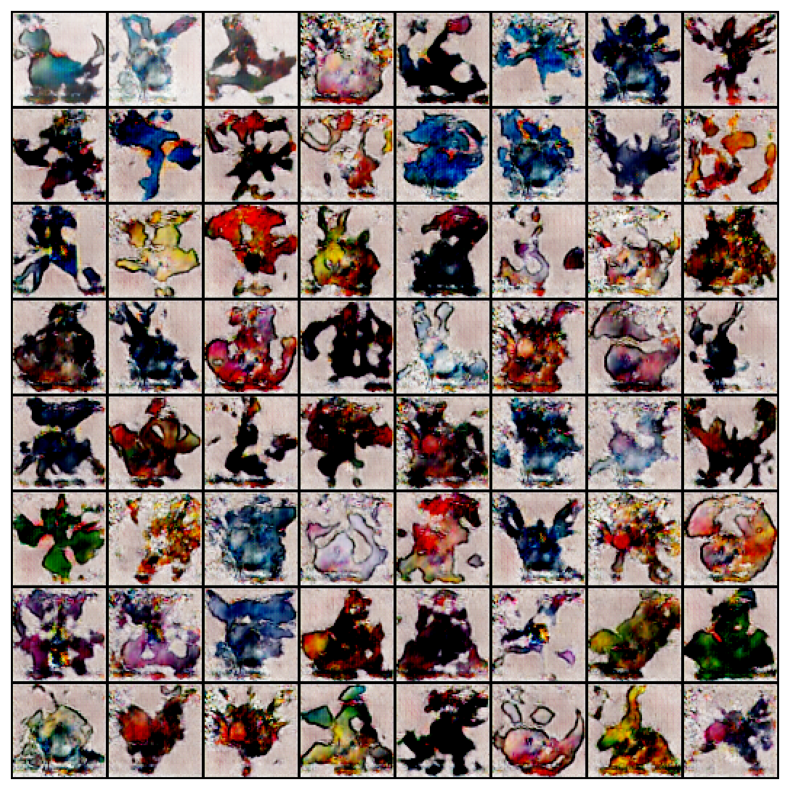

In [174]:
show_images(fake_images)

*Вывод:* AEGAN действительно обучается стабильнее и выдает более хорошие результаты, чем AEGAN. Модель обучалась 1460 эпох. Покемоны получаются различной формы, довольно неадекватная раскраска, но при этом покемоны получаются различные, и у некоторых из них присутствуют детали в виде клюва, ушей, хвоста и т.д. Возможно при большем количестве данных и более долгом обучении результаты были бы лучше.

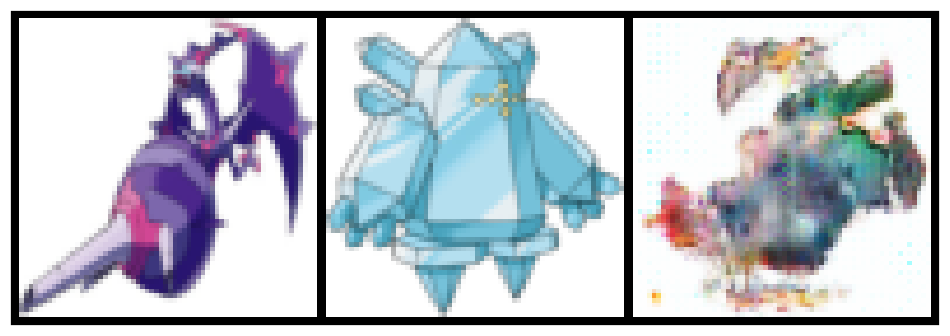

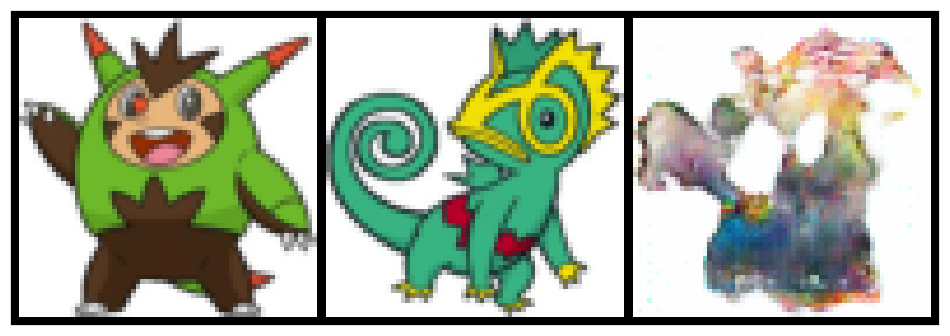

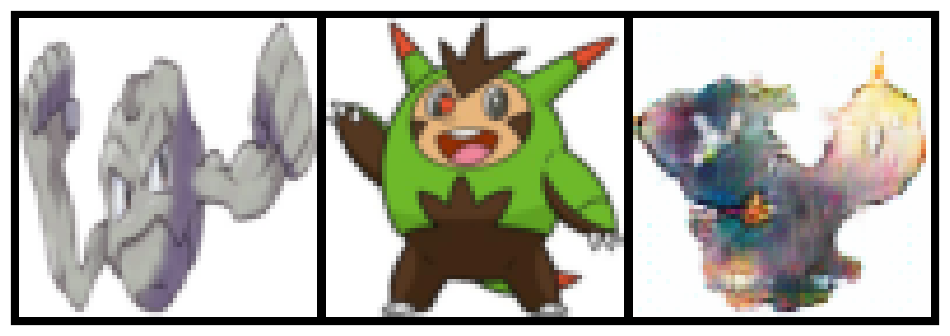

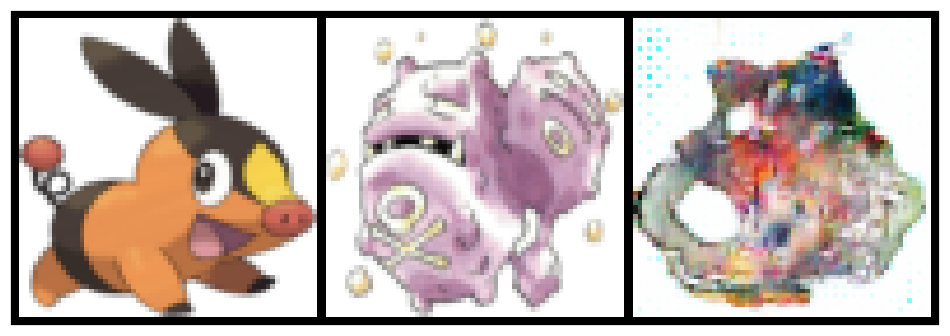

In [198]:
for (images, _) in dataloader:
    for j in range(4):
        ind1 = np.random.randint(0, batch_size)
        ind2 = np.random.randint(0, batch_size)

        img1 = images[ind1]
        img2 = images[ind2]

        vector1 = aegan["encoder"](img1[None, :])
        vector2 = aegan["encoder"](img2[None, :])

        alpha = 0.5

        sum_v = alpha * vector1 + vector2 * (1 - alpha)
        sum_img = torch.squeeze(aegan["generator"](sum_v))
        show_images(torch.stack([img1, img2, sum_img]))

    break

Также одним из плюсов AEGAN было заявлено умение интерполировать изображения, то есть если взять сумму двух покемонов, то должен получиться покемон. В принципе, с учетом качества модели видно, что если сложить 2 покемонов из датасета, то получится что-то, что тоже является "покемоном" (в данном случае - очертания), и результат разный и зависит от исходных картинок.